# Data and Training scripts

Following this guide: https://www.learnpytorch.io/08_pytorch_paper_replicating/

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [12]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.optim import Adam
import torchvision
from torch.utils.data import DataLoader
import numpy as np

In [14]:
"""
data_setup.py

Contains functionality for creating PyTorch DataLoaders for 
image classification data.
"""
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False, # don't need to shuffle test data
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [15]:
"""
Train and Test

Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval() 

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]} 
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

In [16]:
"""
save_model.py

Contains various utility functions for PyTorch model training and saving.
"""
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

In [29]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

# Get Data

In [38]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="/pizza_steak_sushi")
image_path

[INFO] /pizza_steak_sushi directory exists, skipping download.


PosixPath('/pizza_steak_sushi')

In [66]:
train_dir = "/kaggle/working/data" + str(image_path) + "/train"
test_dir = "/kaggle/working/data" + str(image_path) + "/test"
train_dir, test_dir

('/kaggle/working/data/pizza_steak_sushi/train',
 '/kaggle/working/data/pizza_steak_sushi/test')

In [40]:
# Params

# Data
IMG_SIZE = 224
BATCH_SIZE = 32 # 4096 in the paper

In [42]:
# Transforms

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [67]:
# Dataloaders

train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)
train_dataloader, test_dataloader, class_names


(<torch.utils.data.dataloader.DataLoader at 0x78ccab1fd3d0>,
 ['pizza', 'steak', 'sushi'])

In [69]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(-0.5, 223.5, 223.5, -0.5)

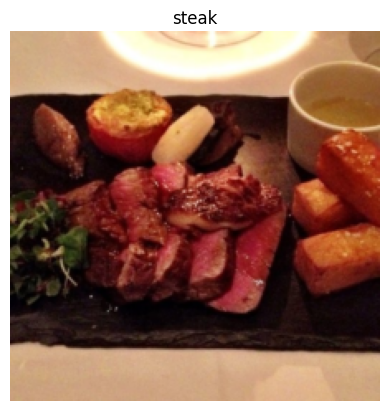

In [71]:
import matplotlib.pyplot as plt
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

# ViT

## Overview

Parts:
- Patch + Position Embedding
- Linear projection: patch turned into a learnable embedding
- Layer Norm: regularizing per layer distribution (over activations per hidden unit in a layer)
- Multi-head self attention (MSA)
- MLP + GELU
- Transformer Encoder
- MLP Head

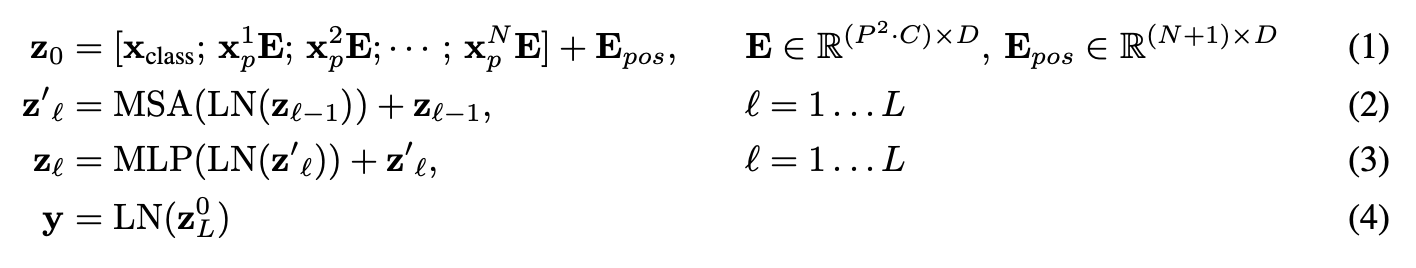

## Equations

Eq 1: Transformer keeps constant latent vector size D. Flatten patches to D dimensions with a trainable linear projection. (Patch Embeddings + Position Embeddings)  
Eq 2 / 3: LN + MSA + LN + MLP + Residual Connection  
Eq 4: prepend classification token (gets global attention from all patches)  
* $\displaystyle \mathbf{z}_{0}$ is “z zero” (this is the output of the initial patch embedding layer).
* $\displaystyle \mathbf{z}_{\ell}^{\prime}$ is “z of a particular layer prime” (an intermediary value of $\mathbf{z}$).
* $\displaystyle \mathbf{z}_{\ell}$ is “z of a particular layer.”
* And $\displaystyle \mathbf{y}$ is the overall output of the architecture.

- E*x = Embedding * image patch (linear projection to flatten patches) in (1)
- $l$ is layer for residual connections in (2) and (3)
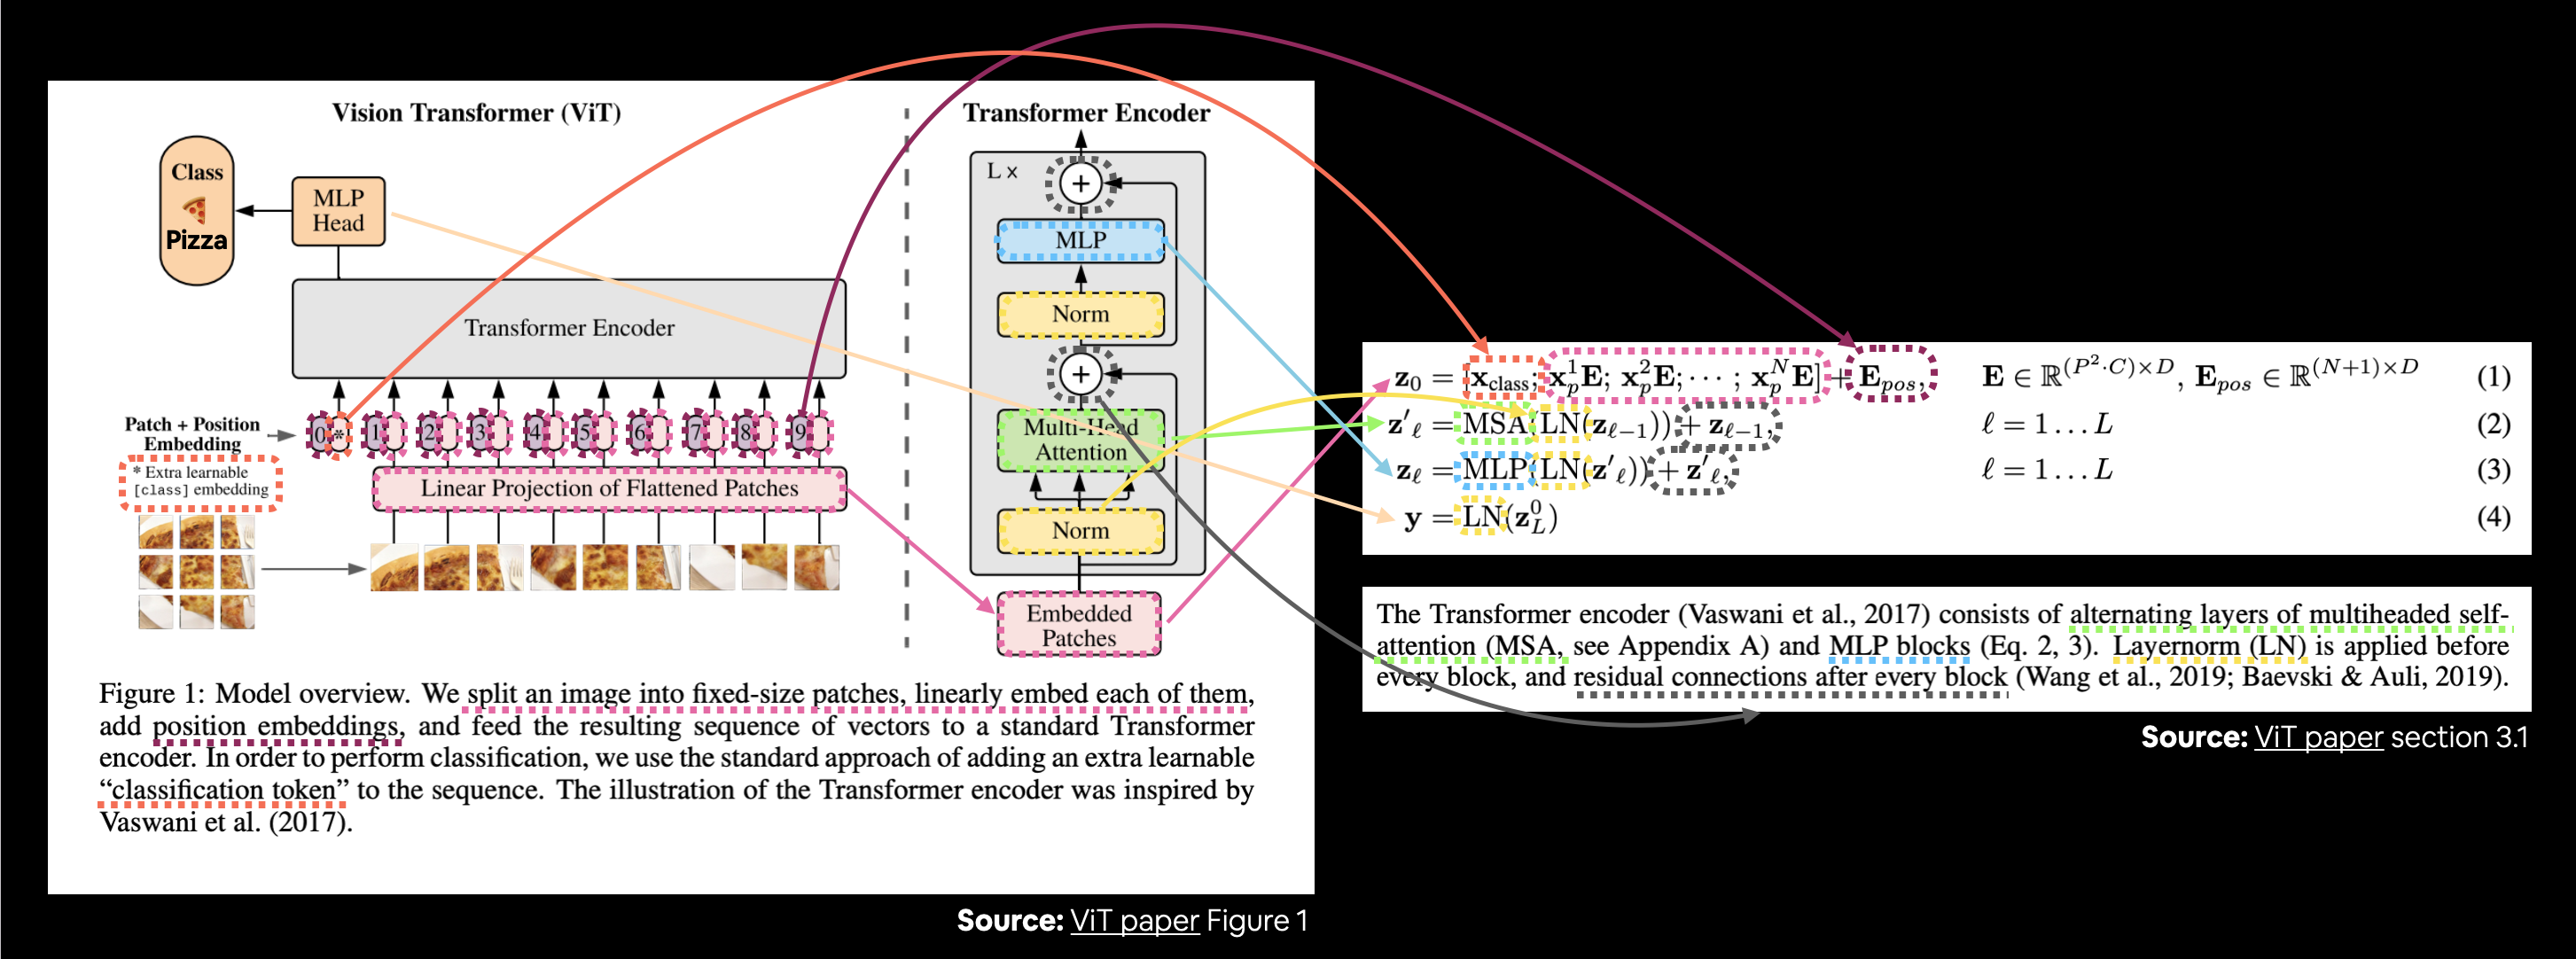

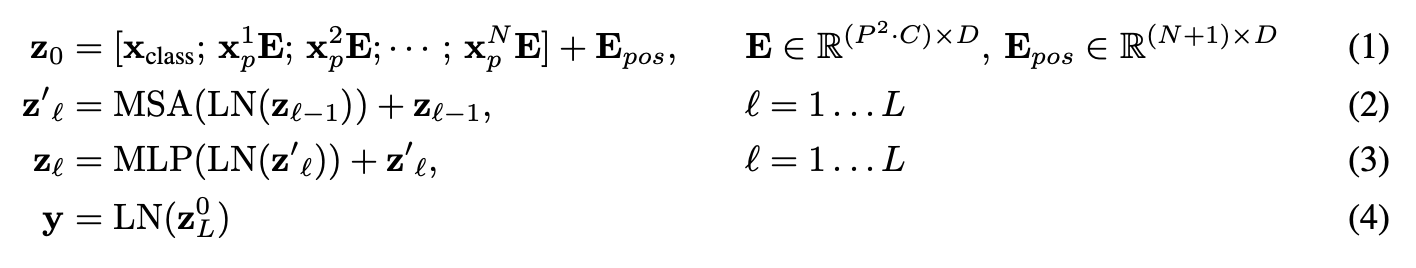
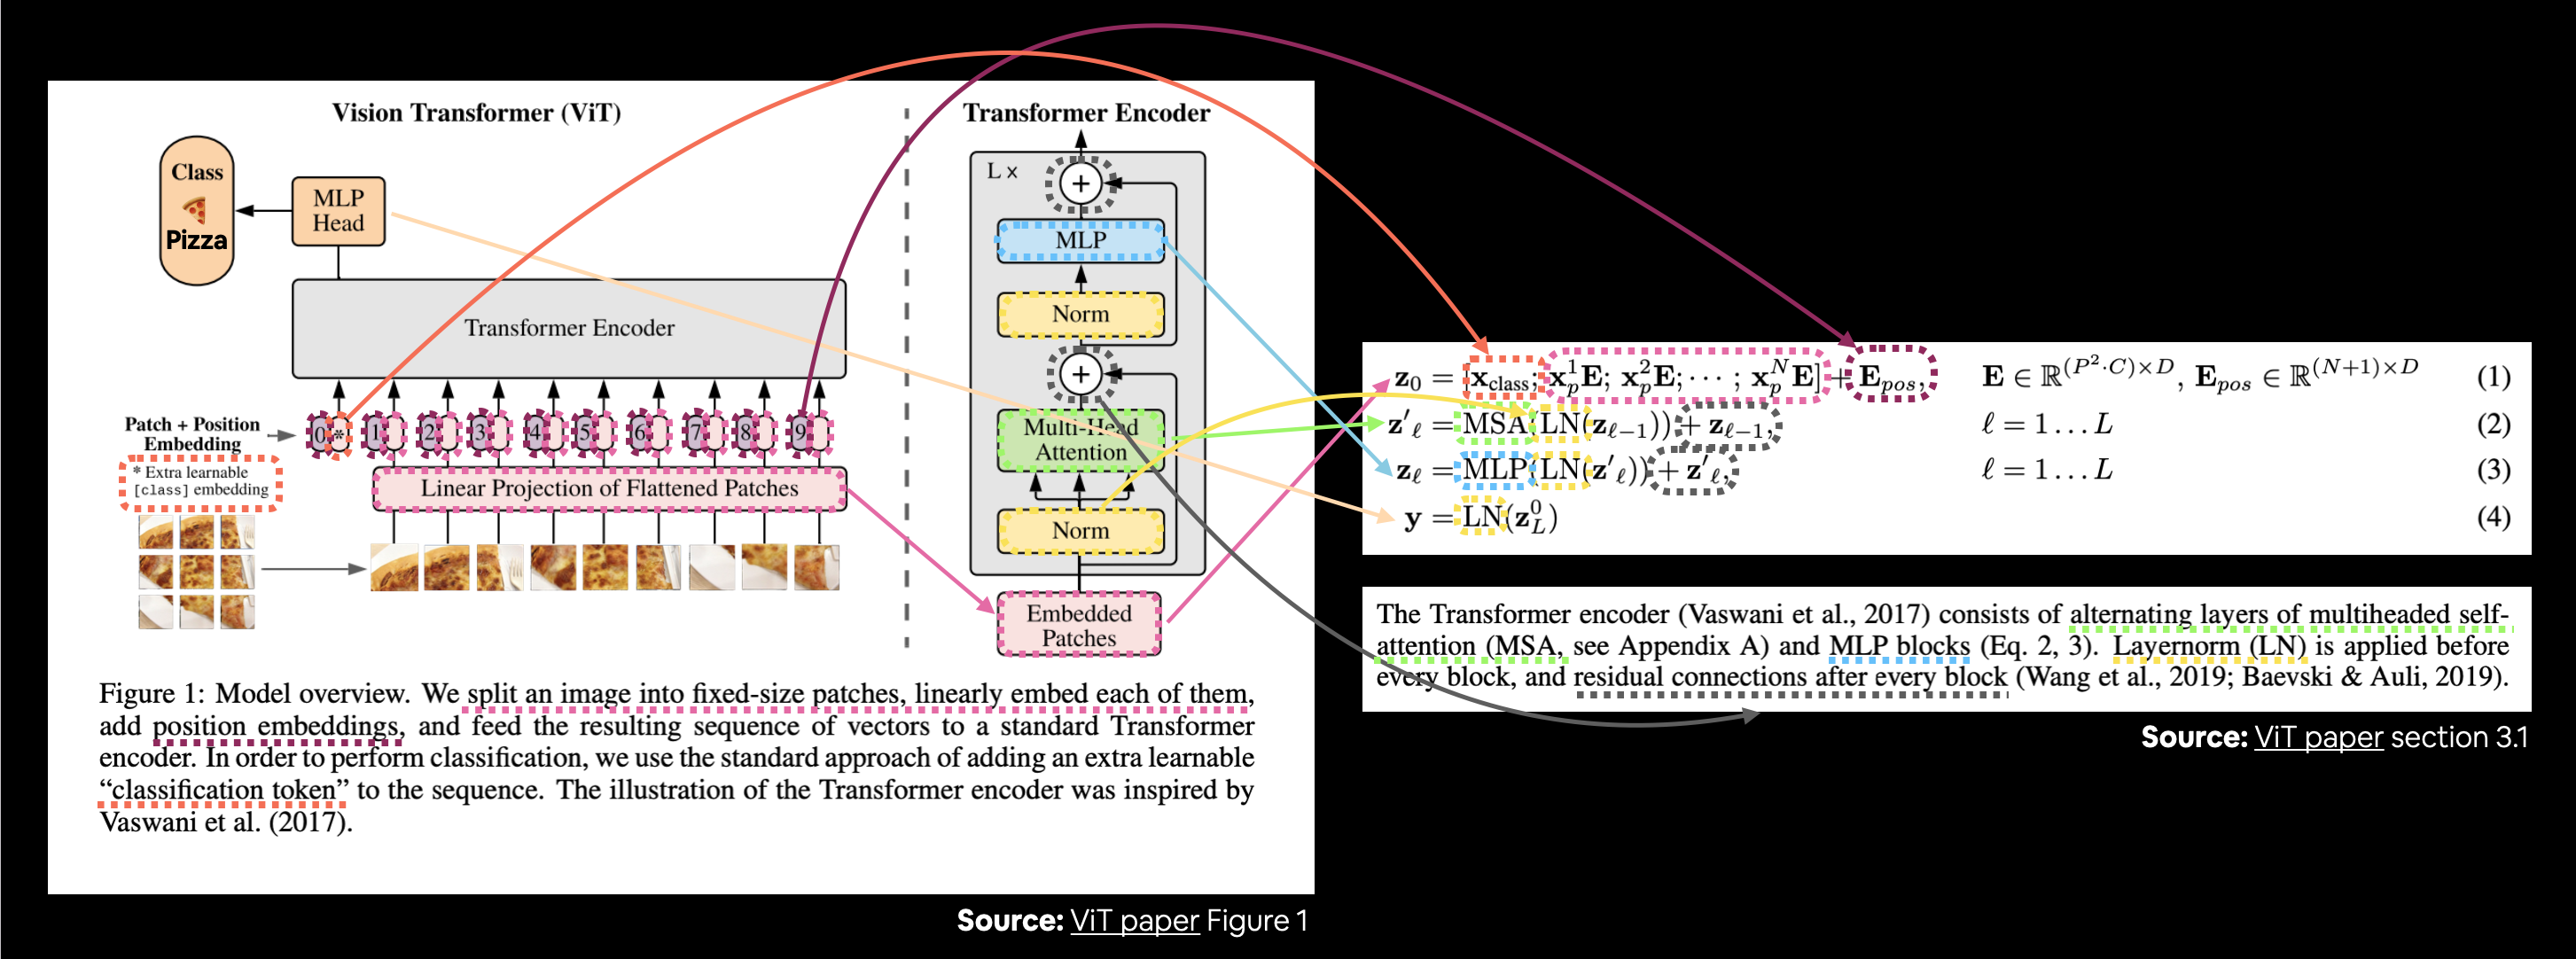

## Eq 1. Patch Embeddings

$$ \begin{aligned} \mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D} \end{aligned} $$

- E is patch and position embedding
- N is # of patches
- D is # of input dims to encoder (E is linear projection to D)
- P is patch dim. and C is # of channels

`x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]`

## Eq 2. MSA

$$ \begin{aligned} \mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \end{aligned} $$

`x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input`
- layer norm and MSA input then add original input for residual connection
- $l$ is the encoder layer we are at (1 to $L$)

## Eq 3. MLP

$$ \begin{aligned} \mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\ \end{aligned} $$

- same as (2) but with a MLP

## Eq 4. Classification token

$$ \begin{aligned} \mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & & \end{aligned} $$


y = Linear_layer(LN_layer(x_output_MLP_block[0]))


ViT Base:
- layers: 12
- hidden size (D): 768 (Embedding dimension for QKV and linear projection)
- MLP size: 3072
- Heads: 12 (for Multi-head)
- total params: 86M

# Embedding Layer

In [75]:
# Params
height, width = 224, 224
color_channels = 3
patch_size = 16

N = int((height * width) / patch_size**2) # num of patches
"num of patches", N

('num of patches', 196)



$$
\underbrace{H \times W \times C}_{\text{Input image}}
\quad\longrightarrow\quad
\underbrace{N \times \bigl(P^2 \cdot C\bigr)}_{\substack{\text{Sequence of flattened}\\\text{patches}}}
$$

where

$$
N \;=\;\frac{H\,W}{P^2}\,. 
$$

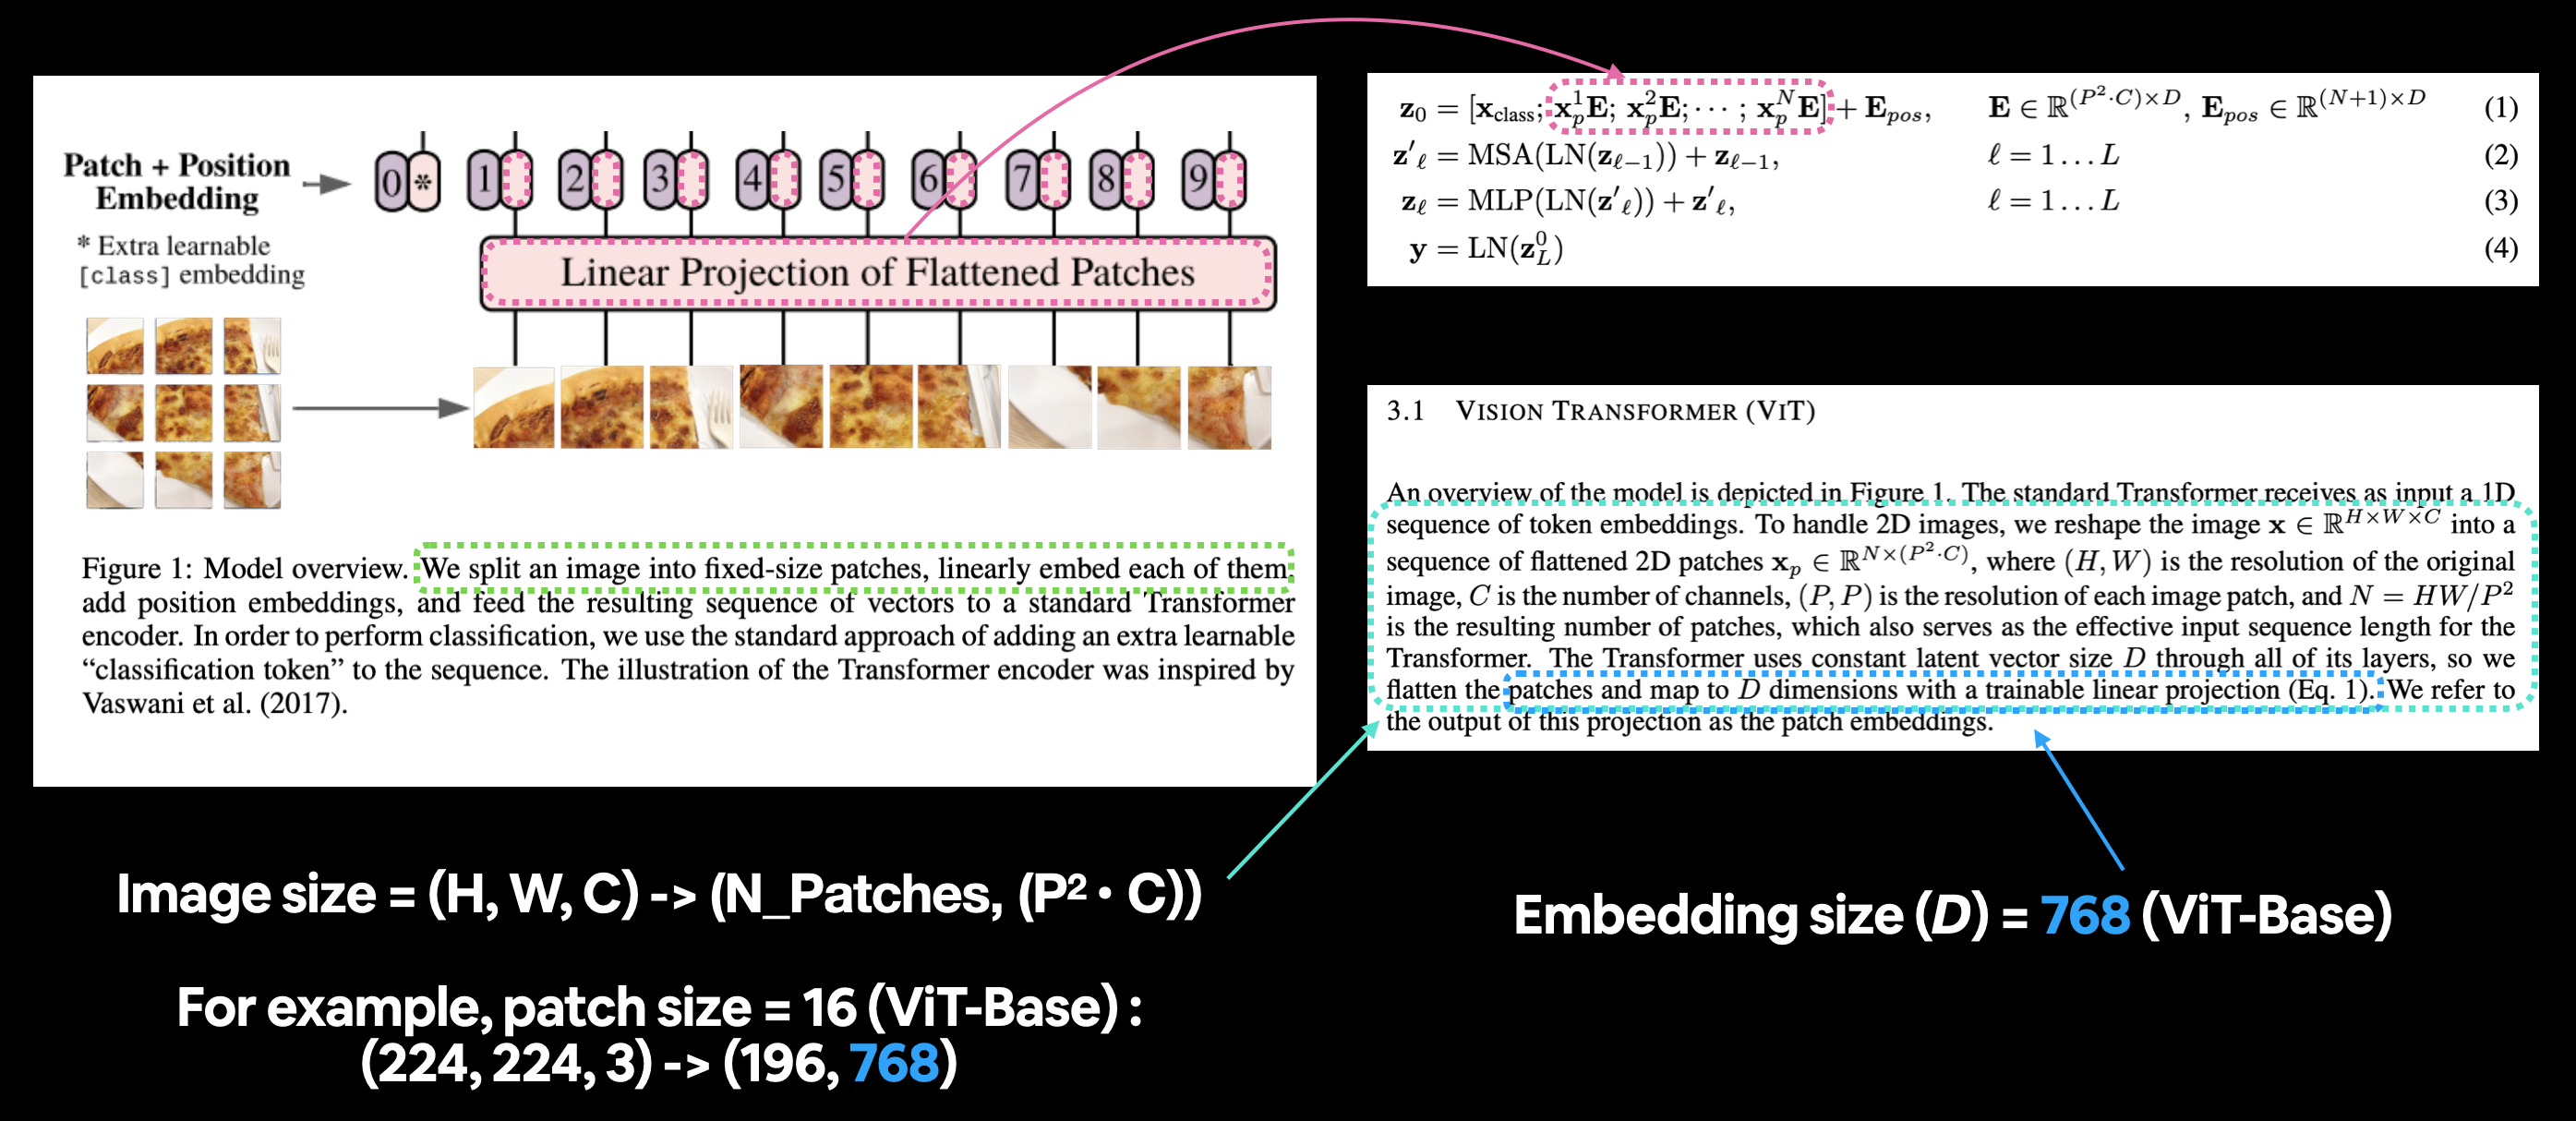

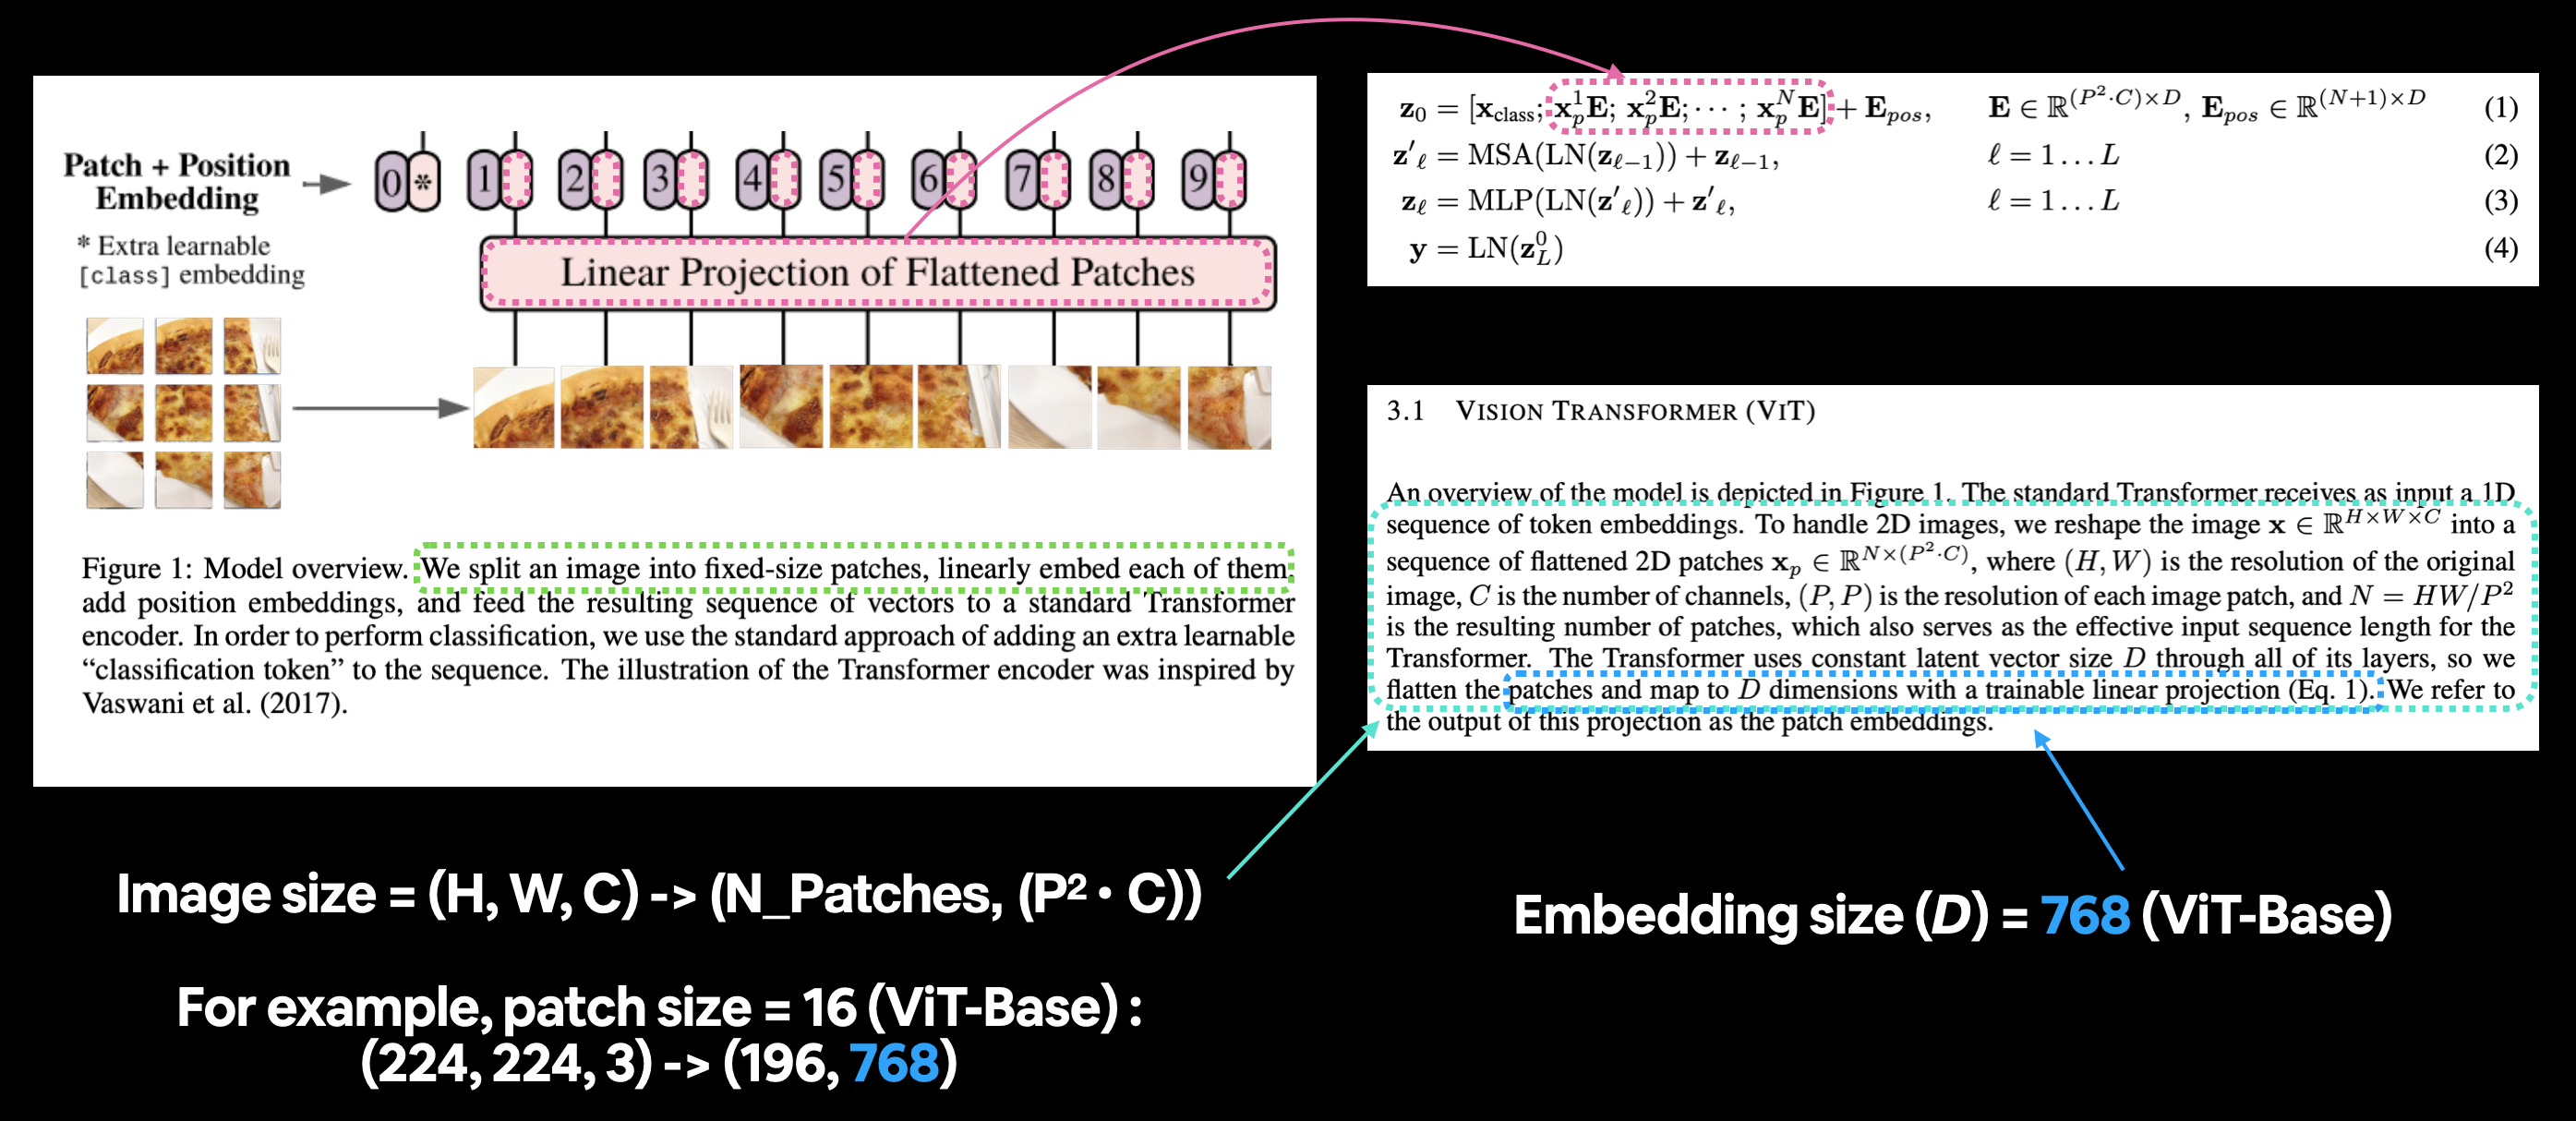

In [76]:
# embedding shapes

embedding_input_shape = (height, width, color_channels)

# (H,W,C) -> (N, P^2 * C)
embedding_output_shape = (N, patch_size**2 * color_channels)
embedding_input_shape, embedding_output_shape

((224, 224, 3), (196, 768))

# of patches per row 14
Patch size: 16 x 16


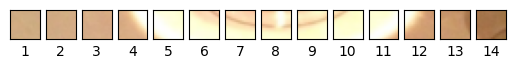

In [86]:
img_size = 224
patch_size = 16
num_patches = img_size//patch_size # per row/col
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print("# of patches per row", num_patches)
print("Patch size:", patch_size, "x", patch_size)
fig, axs = plt.subplots(nrows=1, 
                        ncols=num_patches)

image_permuted = image.permute(1,2,0)
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

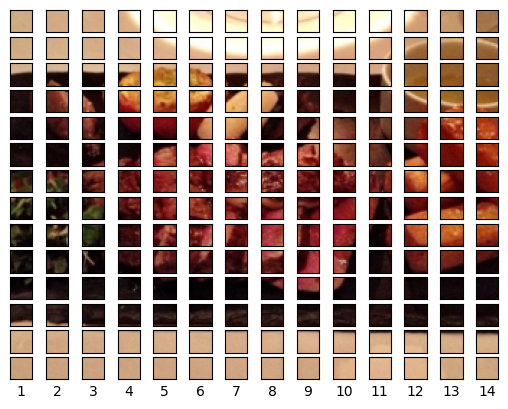

In [96]:
fig, axs = plt.subplots(nrows=num_patches, 
                        ncols=num_patches, sharex=True, sharey=True)

image_permuted = image.permute(1,2,0) # for matplotlib
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):

        # slice image by patch height and width
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                         patch_width:patch_width+patch_size,
                                         :])

        axs[i, j].set_xlabel(j+1)
        # axs[i, j].set_ylabel(i+1, rotation="horizontal", horizontalalignment="right", verticalalignment="center")
        
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

# patchify image

In [100]:
# create learnable embeddings using Conv2d
# image -> patches -> embedding
# (H, W, C) -> (N, P^2 * C)
# (224, 224, 3) -> (196, 768)

conv2d = nn.Conv2d(in_channels=3, 
                   out_channels=768, # Embedding size D
                  kernel_size=patch_size, 
                  stride=patch_size, # step to next patch
                  padding=0)

print(image.unsqueeze(0).shape)
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 768, 14, 14])


### Conv2D explained:
- input: torch.Size([1, 3, 224, 224])
- output: torch.Size([1, 768, 14, 14])

Goal: for each patch, get a 768 dim embedding vector

Intuitively: take 16x16 patch, run thru MLP, and get 768 dim output

- take image and apply conv filters translating 3 channels to 768 channels
- one conv filter is equivalent to NN forward pass
(since conv filter is weighted sum on patch; same as NN -> both result in a single number)
- result is "one channel" has a single number for each patch in 2D
- reorder channel-wise to get the embedding vectors now :)

Showing random convolutional feature maps from indexes: [150, 401, 70, 540, 148]


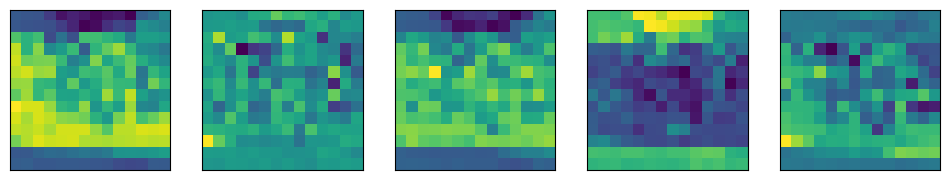

In [102]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 768), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps (conv2d outputs of patches [0, 768])
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [104]:
# flatten spatial dims of image conv
# each channel flattened
flatten = nn.Flatten(start_dim=2, end_dim=3)

image_flattened = flatten(image_out_of_conv)
print(image_out_of_conv.shape, image_flattened.shape)

torch.Size([1, 768, 14, 14]) torch.Size([1, 768, 196])


embedding dim (D) is vector size  
num of patches (N) is the sequence length

In [106]:
# reorder so each patch has 768 dim embedding
embedding = image_flattened.permute(0, 2, 1)
embedding.shape, "[batch_size, num_patches, embedding_size]"

(torch.Size([1, 196, 768]), '[batch_size, num_patches, embedding_size]')

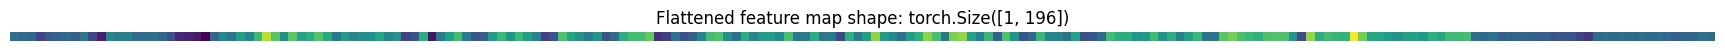

In [107]:
# first index in embedding for every patch in sequence
# output of patch embedding

single_flattened_feature_map = embedding[:, :, 0]
# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [113]:
class PatchEmbedding(nn.Module):
    """Turns 2D image into 1D embedding vector for ViT

    Args:
        in_channels (int): # of color channels
        patch_size (int): size of patches
        embedding_dim (int): Size of embedding to turn image into
    """

    def __init__(self,
                in_channels=3,
                patch_size=16,
                embedding_dim=768):
        super().__init__()

        # Patchify layer
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                out_channels=embedding_dim,
                                kernel_size=patch_size,
                                stride=patch_size,
                                padding=0)

        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x): # input: [batch_size, 3, 224, 224]
        image_resolution = x.shape[-1] # C, H, W
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        x_patched = self.patcher(x) # [batch_size, 768, 14, 14]
        x_flattened = self.flatten(x_patched) # [batch_size, 768, 196]
        return x_flattened.permute(0, 2, 1) # [batch_size, N, P^2 * C] -> [batch_size, 196, 768]

In [114]:
# test out PatchEmbedding Layer

patchify = PatchEmbedding()
# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

# N = H * W / 2
# D = P^2 * C

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


Equation 1 done!

In [118]:
from torchinfo import summary
summary(PatchEmbedding(), input_size=(1, 3, 224, 224),
       #         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

Layer (type:depth-idx)                   Output Shape              Param #
PatchEmbedding                           [1, 196, 768]             --
├─Conv2d: 1-1                            [1, 768, 14, 14]          590,592
├─Flatten: 1-2                           [1, 768, 196]             --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17